In [3]:
!pip install gensim

^C


In [14]:

import pandas as pd
import numpy as np
import json

#Loading additional helper functions not shown here but provided in the folder
#%run nlp_utils_news.ipynb

#copy code
import itertools, string, operator, re, unicodedata, nltk
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from bs4 import BeautifulSoup
from itertools import combinations
from gensim.models import Phrases
from collections import Counter

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [18]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Panku\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Panku\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
#Contraction map
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\']

stop_words = ENGLISH_STOP_WORDS.union(add_stop)

tokenizer = TweetTokenizer()
pattern = r"(?u)\b\w\w+\b" 

lemmatizer = WordNetLemmatizer()

punc = list(set(string.punctuation))

def casual_tokenizer(text): #Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
    tokens = tokenizer.tokenize(text)
    return tokens

#Function to replace the nltk pos tags with the corresponding wordnet pos tag to use the wordnet lemmatizer
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

def remove_html(text):
    soup = BeautifulSoup(text, "html5lib")
    tags_del = soup.get_text()
    uni = unicodedata.normalize("NFKD", tags_del)
    bracket_del = re.sub(r'\[.*?\]', '  ', uni)
    apostrphe = re.sub('’', "'", bracket_del)
    string = apostrphe.replace('\r','  ')
    string = string.replace('\n','  ')
    extra_space = re.sub(' +',' ', string)
    return extra_space

def process_text(text):
    
    soup = BeautifulSoup(text, "lxml")
    tags_del = soup.get_text()
    no_html = re.sub('<[^>]*>', '', tags_del)
    tokenized = casual_tokenizer(no_html)
    lower = [item.lower() for item in tokenized]
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    tagged = nltk.pos_tag(decontract)
    lemma = lemma_wordnet(tagged)
    no_num = [re.sub('[0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    return no_stop

def word_count(text):
    return len(str(text).split(' '))

def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

def word_freq_bigrams(clean_text_list, top_n):
    """
    Word Frequency With Bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [20]:

#Load the JSON Data into a df

data = []

for line in open(r'C:\Users\Panku\OneDrive\Desktop\ML projects\DS projects\Text Classification\NewsClassificationDataSet.json', 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [21]:
#Apply the function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words

df['clean_text'] = df['content'].apply(process_text)
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second, team, roc..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[it is, barely, dawn, mike, fitzpatrick, start..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california's, smog-fighting, agency..."


In [22]:
#Top 20 most frequent words for all the articles

cl_text_list = df['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.head(20)

,0,1
0,new,1077
1,reuters,793
2,year,699
3,company,590
4,quot,551
5,monday,498
6,tuesday,497
7,thursday,458
8,wednesday,447
9,win,418


In [23]:
#Avg word count by category

df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


In [24]:

#Preparing the dataframes

#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']

#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=1005, replace=True, random_state=3)
df_sports = df_sports.sample(n=805, replace=True, random_state=3)

#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
Business    1000
SciTech     1895
Sports       800
World       1895
Name: content, dtype: int64

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

array([0, 2, 1, 3])

In [25]:
#Top 15 words by category. Taking bigrams into account

top_n = 15

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,122,new,186,win,105,monday,129
1,new_york,101,company,180,game,74,reuters,119
2,year,81,quot,132,team,74,tuesday,118
3,thursday,80,software,123,season,58,friday,116
4,reuters,75,microsoft,106,quot,56,iraq,115
5,friday,67,technology,106,lead,53,quot,105
6,monday,66,make,103,victory,47,wednesday,105
7,new,58,use,102,year,45,official,104
8,market,55,year,100,sunday,43,country,103
9,sale,51,reuters,100,play,40,leader,102


In [26]:
#Top 15 bigrams by category

bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,new_york,101,microsoft_corp,47,new_york,36,prime_minister,88
1,oil_price,45,mobile_phone,41,sport_network,30,president_bush,58
2,united_state,25,san_francisco,29,united_state,22,united_nation,55
3,quote_profile,25,new_york,28,red_sox,17,united_state,48
4,wall_street,21,video_game,28,los_angeles,15,yasser_arafat,37
5,washington_reuters,18,search_engine,27,manchester_unite,13,presidential_election,36
6,crude_oil,18,apple_computer,23,san_francisco,11,kill_people,35
7,london_reuters,16,year_ago,19,champion_league,11,new_york,34
8,san_francisco,15,sun_microsystems,19,major_league,11,north_korea,33
9,chief_executive,11,united_state,19,wednesday_night,10,canadian_press,28


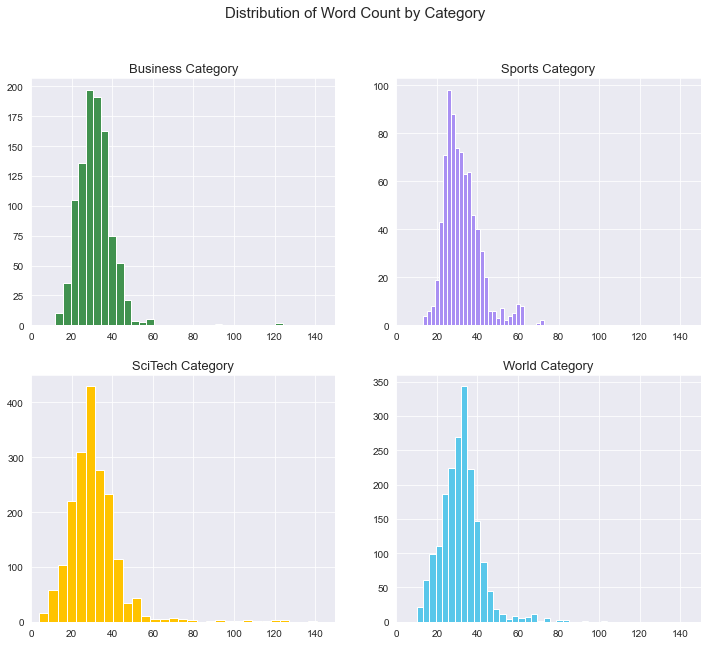

In [27]:
#Plot the distribution of word count by article

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

In [28]:
#Creating the features (tf-idf weights) for the processed text

texts = df['clean_text'].astype('str')
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(5590, 18649)
(5590,)


In [29]:

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(5590, 100)

In [30]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Random Forest,0.83,0.83,0.82,0.82
1,Stochastic Gradient Descent,0.79,0.80,0.76,0.77
4,AdaBoost,0.74,0.73,0.73,0.73
3,Decsision Tree,0.72,0.70,0.71,0.70
6,K Nearest Neighbor,0.71,0.69,0.70,0.69
5,Gaussian Naive Bayes,0.67,0.67,0.69,0.65
0,Dummy,0.34,0.08,0.25,0.13


In [31]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 1110.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 1293.1min


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


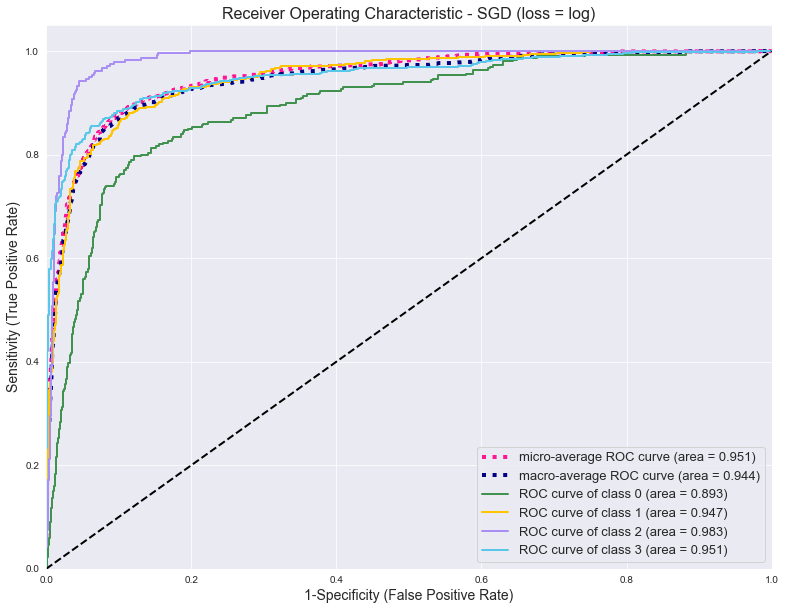

In [32]:
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()